In [42]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import *
from numpy import linalg as LA

### Logistic Regression Module

In [89]:
class SimpleLogisiticModelBinary:
    
    def __init__(self, x, y ):
        '''
        initializes an array of size [row, col]  where row=1 (value of m-- no of x,y pairs) 
        and col = size of x
        # consturctors used to initialize the variables of an object
        '''
        self.w = np.zeros((1, x.shape[-1])) 
        self.b = 0.0
        
    def linear(self, x, activation): 
        '''
        # takes x and plots a sigmoid func for the probability
        # dot is used to mat mul r= wx+b for all the matix r is result
        '''
        r = np.dot(self.w, x.T) + self.b 
        if activation == 'sigmoid':
            r = self.sigmoid(r)
        return r
    
    def sigmoid(self,x):
        return 1/(1 + np.exp(-x))
    
    def calculate_loss(self, x, y): 
        '''
        # losses returns weight and bias
        '''
        num = x.shape[0]
        predict = self.linear(x, activation='sigmoid')
        gold = y.T #transpose
        loss = -(np.sum((gold*np.log(predict)) + ((1-gold)*(np.log(1-predict)))))/num
        dw = (np.dot(x.T, (predict-gold).T))/num  #d/dw received which would be used with Loss later on
        db = (np.sum(predict-gold.T))/num
        grads = {
            "dw": dw,
            "db": db
        }
        return  grads, loss
    
    def train(self, x, y, lr, itr): #learn algo
        result = []
        for i in tqdm(range(itr)):
            grads, loss = self.calculate_loss(x, y)
            dw =  grads["dw"]
            db =  grads["db"]
            result.append({  #to be used for plotting loss VS itr so that we know for how many iteration the model has to be trained
                "itr":i,
                "loss":loss
            })
            self.w = self.w - (lr * (dw.T)) #Learn Algo
            self.b = self.b - (lr * db) # Eqn-1
            result.append({
                "itr": i,
                "loss":loss
            })
        return result
        
    
    def predict(self, x):
        _pred = self.linear(x, activation="sigmoid").tolist()[0]
        return _pred

### Data Creation

In [90]:
def get_data(no_f_samples : int, no_of_ftrs: int, no_of_classes: int):
    X = np.random.rand(no_f_samples , no_of_ftrs)
    #X = round(random.random(Xtemp), 2))
    Y = np.random.randint(no_of_classes, size = no_f_samples)
    print(type(X))
    return X , Y


def visualize_data(X , Y):    
    fig, ax = plt.subplots()
    ax.scatter(x=X[:,0], y=X[:,1], c=Y)
    print("x-shape", X.shape, 'y-shape', Y.shape)
    
    

def copy_data_classwise(no_of_classes: int, no_of_samples: int,  X, Y):
    dataXY = {}
    for i in range(no_of_classes):
        #Xtempdict = {
        _y = Y.tolist()
        for xi in range(len(_y)):
            if i == _y[xi]:
                _y[xi] = 1
            else:
                _y[xi] = 0
        dataXY["Label-"+str(i)] = {
            "X" : X.tolist(),
            "Y": _y
        }

    return dataXY

<class 'numpy.ndarray'>
x-shape (2000, 4) y-shape (2000,)


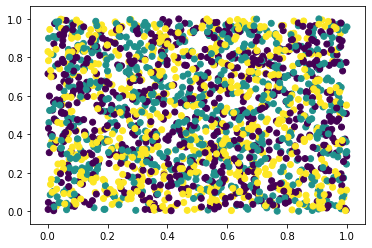

In [91]:
X1 , Y1 = get_data(no_f_samples = 2000, no_of_ftrs = 4, no_of_classes = 3)
visualize_data(X1, Y1)

In [92]:
class_wise_data = copy_data_classwise(no_of_classes=3, no_of_samples=2000, X=X1, Y=Y1)
f = open('./T-LR-3-class-data_4-6-20.json', 'w')
json.dump(class_wise_data, f)
f.close()

#### Struct. of Data

In [93]:
for k,v in class_wise_data.items():
    print(f"{k} {v.keys()}")

Label-0 dict_keys(['X', 'Y'])
Label-1 dict_keys(['X', 'Y'])
Label-2 dict_keys(['X', 'Y'])


### Training 

In [94]:
def make_cv_split(x, y, fold=4):
    count_per_fold = len(x)/fold
    dict_split = {} # k = 1 value =  [["X": Y], [], ..., 1200] e3
    s = 0
    for i in range(fold):
        z = int(s + count_per_fold)
        if z >= len(x):
            z = len(x)
        f_x = x[int(s):int(z)]
        f_y = y[int(s):int(z)]
        dict_split[str(i+1)] =  (f_x, f_y) #contains a splitted dict with tuple of np arrays (x1,y1), (x2,y2)..
        s += count_per_fold
    
    #for k,v in dict_split.items():
    #    print(k, len(v[0]))
    
    cv_dict = {} # k = 1 value = {"train": { "x": []e3, "y":[]}, "test": {"x":[], "y": []}}
    for f,v in dict_split.items():
        tt_x, tt_y = v # test
        tx = []
        ty = []
        #print(f" Making Training Data For Fold {f}")
        for i in range(fold):
            if (i+1) != f:
                _x, _y = dict_split[str(i+1)]
                for e,g in zip(_x, _y):
                    tx.append(e)
                    ty.append(g)
        xtr, ytr = tx , ty
        #print(xtr[:5])
        #print(f"length of xtr ----> {len(xtr)} \n")
        #print(ytr[:5])
        #print(f"length of ytr ----> {len(ytr)} \n")
        xtt, ytt = tt_x, tt_y
        cv_dict[str(f)] = {
            "train":{
                "x":xtr,
                "y":ytr
            },
            "test":{
                "x":xtt,
                "y":ytt
            }
        }
    return cv_dict  

In [95]:
class T_Evaluation:
    
    def __init__(self, gold, pred):
        self.Y = gold
        self.Ypred  = pred
        
    def calc_performance_metrics(self, YpredInput): 
        #global inp ,tp1, tn0, fp1, fn0, performance, precision, accuracy, Y, Ypred, recall, F1, Specificity
        tp1 = tn0 = 0 
        fp1 = fn0 = 0
        accuracy = precision = recall = F1 = Specificity = 0.
        performance = {}
        inp = YpredInput
        for i in range(len(self.Y)):
            if self.Ypred[i] == inp:
                if self.Ypred[i] == self.Y[i]:
                    tp1 += 1
                else:
                    fp1 += 1
            else:
                if self.Ypred[i] == self.Y[i]:
                    tn0 += 1
                else:
                    fn0 += 1
          
        accuracy = (tp1 + fn0)/ float(tp1 + tn0 + fp1 + fn0)
        if (tp1 + fp1) == 0:
            precision = 0
        else:
            precision = (tp1)/ float(tp1 + fp1)
        
        if (tp1 + fn0) == 0:
            recall = 0
        else:
            recall = (tp1)/ float(tp1 + fn0)
            
        if ((precision + recall)) == 0:
            F1 = 0
        else:
            F1 = (2 * precision * recall)/ float(precision + recall)
            
        
        performance["tp1"] = tp1
        performance["fp1"] = fp1
        performance["tn0"] = tn0
        performance["fn0"] = fn0
        performance["accuracy"] = accuracy
        performance["precision"] = precision
        performance["recall"] = recall
        performance["F1"]  = F1
        return performance

In [96]:
cls0 = None
cls1 = None
cls2 = None

for ks,v in class_wise_data.items():
    x, y = v["X"], v["Y"]
    if ks.endswith('-0'):
        cvdict = make_cv_split(x, y, fold=3)
        score = 0
        # training kfold
        for k in cvdict.keys():
            train_x, train_y = cvdict[k]["train"]["x"], cvdict[k]["train"]["y"]
            test_x, test_y = cvdict[k]["test"]["x"], cvdict[k]["test"]["y"]
            train_x = np.array(train_x)
            train_y = np.array(train_y)
            test_x = np.array(test_x)
            test_y = np.array(test_y)
            cls0 = SimpleLogisiticModelBinary(train_x, train_y)
            cls0.train(train_x, train_y, 0.05, 10000)
            pred_y = cls0.predict(test_x)
            pred_y = [1 if p>0.5 else 0 for p in pred_y]
            evl = T_Evaluation(gold=test_y, pred=pred_y)
            eval_dict = evl.calc_performance_metrics(YpredInput=1)
            score += eval_dict["F1"]
        score = score/float(3) 
        print(f" Training CV Score for {ks} ---> {score}")
    elif ks.endswith('-1'):
        cvdict = make_cv_split(x, y, fold=3)
        score = 0
        for k in cvdict.keys():
            train_x, train_y = cvdict[k]["train"]["x"], cvdict[k]["train"]["y"]
            test_x, test_y = cvdict[k]["test"]["x"], cvdict[k]["test"]["y"]
            train_x = np.array(train_x)
            train_y = np.array(train_y)
            test_x = np.array(test_x)
            test_y = np.array(test_y)
            cls1 = SimpleLogisiticModelBinary(train_x, train_y)
            cls1.train(train_x, train_y, 0.05, 10000)
            pred_y = cls1.predict(test_x)
            pred_y = [1 if p>0.5 else 0 for p in pred_y]
            evl = T_Evaluation(gold=test_y, pred=pred_y)
            eval_dict = evl.calc_performance_metrics(YpredInput=1)
            score += eval_dict["F1"]
        score = score/float(3) 
        print(f" Training CV Score for {ks} ---> {score}")
    else:
        cvdict = make_cv_split(x, y, fold=3)
        score = 0
        for k in cvdict.keys():
            train_x, train_y = cvdict[k]["train"]["x"], cvdict[k]["train"]["y"]
            test_x, test_y = cvdict[k]["test"]["x"], cvdict[k]["test"]["y"]
            train_x = np.array(train_x)
            train_y = np.array(train_y)
            test_x = np.array(test_x)
            test_y = np.array(test_y)
            cls2 = SimpleLogisiticModelBinary(train_x, train_y)
            cls2.train(train_x, train_y, 0.05, 10000)
            pred_y = cls2.predict(test_x)
            pred_y = [1 if p>0.5 else 0 for p in pred_y]
            evl = T_Evaluation(gold=test_y, pred=pred_y)
            eval_dict = evl.calc_performance_metrics(YpredInput=1)
            score += eval_dict["F1"]
        score = score/float(3) 
        print(f" Training CV Score for {ks} ---> {score}")

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8158.46it/s]


 Training CV Score for Label-0 ---> 0.0


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8621.46it/s]


 Training CV Score for Label-1 ---> 0.0


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8390.58it/s]


 Training CV Score for Label-2 ---> 0.0


In [102]:
def predict_multi_class(x):
    x = np.array(x)
    p = [cls0.predict(x), cls1.predict(x), cls2.predict(x)]
    print(p)
    s = sum(p)
    p = [(x/float(s)) for x in p]
    return p


demo_x = [0.01, 0.002, 0.892, 0.888]
demo_y = predict_multi_class(demo_x)

demo_y

[0.320267884833569, 0.3116034537434026, 0.36860597397877604]
1.0004773125557476


[0.3201150898818841, 0.31145479246041347, 0.36843011765770245]

In [27]:
#importing file from json


import json as js
# file = open("T-LR-3-class-data.json")

# data = file.read()

# print(data)
import os 
#for fname in os.listdir("./"):
#    print(fname)
# file.close()
dict_importedjsonXY = {}
with open("./T-LR-3-class-data_4-6-20.json",'r') as f_in:
    dict_importedjsonXY = js.load(f_in)

In [28]:
X = []
Y = []
for k,v in dict_importedjsonXY.items():
    
    X.extend(v["X"])
    Y.extend(v["Y"])

#print(type(X),X)
#print(type(Y),Y)


npArrayX = np.array(X)
npArrayY = np.array(Y)

#npArrayX.shape
def divide_data_into_test_train(X, Y, trainpecnt: int):
    
    trainlen = 0
    if len(X) != len(Y):
        print("Length of features and class doesnt match")
        return none
 
    else:
        trainlen = int((len(npArrayX)*trainpecnt)/100)
        
    Xtrain = X[:trainlen]
    Xtest = X[trainlen:]
    Ytrain = Y[:trainlen]
    Ytest = Y[trainlen:]
    return Xtrain, Xtest, Ytrain, Ytest

In [29]:
xtrain, xtest, ytrain, ytest = divide_data_into_test_train(npArrayX, npArrayY, trainpecnt = 80)
print(len(xtrain), len(xtest))
#T_bmodel, Tbscore = train_lr_model(X=npArrayX, Y=npArrayY, learning_rate = 0.001, epochs = 10000, output_dir="./")

4800 1200


In [31]:
cvdcit = make_cv_split(x=xtrain, y=ytrain, fold=4)

1 1200
2 1200
3 1200
4 1200
 Making Training Data For Fold 1
[array([0.61990858, 0.98277263, 0.15455602, 0.95152012]), array([0.28171811, 0.2919407 , 0.18114398, 0.74720227]), array([0.22733226, 0.07416398, 0.14163123, 0.65319773]), array([0.51877392, 0.11942068, 0.02401769, 0.84996125]), array([0.207424  , 0.4954818 , 0.06554367, 0.87204302])]
length of xtr ----> 4800 

[0, 0, 0, 0, 1]
length of ytr ----> 4800 

 Making Training Data For Fold 2
[array([0.61990858, 0.98277263, 0.15455602, 0.95152012]), array([0.28171811, 0.2919407 , 0.18114398, 0.74720227]), array([0.22733226, 0.07416398, 0.14163123, 0.65319773]), array([0.51877392, 0.11942068, 0.02401769, 0.84996125]), array([0.207424  , 0.4954818 , 0.06554367, 0.87204302])]
length of xtr ----> 4800 

[0, 0, 0, 0, 1]
length of ytr ----> 4800 

 Making Training Data For Fold 3
[array([0.61990858, 0.98277263, 0.15455602, 0.95152012]), array([0.28171811, 0.2919407 , 0.18114398, 0.74720227]), array([0.22733226, 0.07416398, 0.14163123, 0.6

In [32]:
def train_model(X, Y, learning_rate, epochs):#, output_dir="./"):
    """
    X: input features (None, num_of_ftrs)
    Y: binary class label (None, 1)
    learning_rate: float, [0.0-1.0], must be > 0.0, see Eqn-1 in previous cell
    epochs: int, how many itr
    output_dir = str, path to store the train atrifacts 
    trains on X and Y
    returns model, accuracy_score
    """
    X = np.array(X)
    Y = np.array(Y)
    model = SimpleLogisiticModelBinary(x=X, y=Y)
    result = model.train(x=X, y=Y, lr=learning_rate, itr=epochs)
    y = model.predict(X)
    score = accuracy_score(y,Y)
    df =  pd.DataFrame(result)
    #fig, ax = plt.subplots()
    #ax.scatter(x=X[:,0], y=X[:,1], c=y)
    #df.plot(kind='line',x='itr',y='loss',ax=ax)
    #plt.savefig(output_dir+'training_summ_score_'+str(score)+'.png')
    return model, score

In [33]:
lrs = [0.001, 0.01]
itrs = [10000, 50000]
param_dicts = []
for p1 in lrs:
    for p2 in itrs:
        avg_score = 0.0
        for k,v in cvdcit.items():
            train_x = v["train"]["x"]
            train_y = v["train"]["y"]
            test_x = v["test"]["x"]
            test_y = v["test"]["y"]
            model, score = train_model(X=train_x, Y=train_y, learning_rate=p1, epochs=p2)
            
            pred_y = model.predict(x=test_x)
            score = accuracy_score(test_y, pred_y)
            print(f" Fold {k} Score {score}")
            avg_score += score
        avg_score = avg_score/len(cvdcit)
        param_dicts.append({"lr":p1, "itr":p2, "score":avg_score})
        print(f" LR {p1} ITR {p2} Score {avg_score}")
        
df=pd.DataFrame(param_dicts)
df.head(2)

print(df['score'].max()) #returns maximum of a column of a data frame
 
lattice = df.loc[df['score'].idxmax()] # returns a row for which a row has maximum value 

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4581.74it/s]


 Fold 1 Score 0.6466666666666666


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4609.12it/s]


 Fold 2 Score 0.6708333333333333


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4562.37it/s]


 Fold 3 Score 0.6908333333333333


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4508.09it/s]


 Fold 4 Score 0.6425
 LR 0.001 ITR 10000 Score 0.6627083333333333


100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:11<00:00, 4533.65it/s]


 Fold 1 Score 0.6466666666666666


100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:10<00:00, 4633.75it/s]


 Fold 2 Score 0.6708333333333333


100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:11<00:00, 4222.93it/s]


 Fold 3 Score 0.6908333333333333


100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:12<00:00, 4014.66it/s]


 Fold 4 Score 0.6425
 LR 0.001 ITR 50000 Score 0.6627083333333333


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4208.87it/s]


 Fold 1 Score 0.6466666666666666


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4180.85it/s]


 Fold 2 Score 0.6708333333333333


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4148.02it/s]


 Fold 3 Score 0.6908333333333333


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4324.57it/s]


 Fold 4 Score 0.6425
 LR 0.01 ITR 10000 Score 0.6627083333333333


100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:12<00:00, 4066.84it/s]


 Fold 1 Score 0.6466666666666666


100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:12<00:00, 4069.19it/s]


 Fold 2 Score 0.6708333333333333


100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:12<00:00, 4109.13it/s]


 Fold 3 Score 0.6908333333333333


100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:12<00:00, 3873.99it/s]


 Fold 4 Score 0.6425
 LR 0.01 ITR 50000 Score 0.6627083333333333
0.6627083333333333


In [ ]:
T_bmodel, Tbscore = train_lr_model(X=xtrain, Y=ytrain, learning_rate = 0.001, epochs = 10000, output_dir="./")
print("Trained model is ready to predict the test data")